## Making a striplog (outcrop log thing) for use in Gempy3D

#### First we need to import all of the appropriate libraries

In [1]:
from striplog import Striplog, Component, Interval
import welly
import lasio
from glob import glob
import numpy as np

Have to use `lasio` to read it because `welly` will force regular sampling.

Let's do this in one go and import every *.las file from the directory and append them to a list las_files

In [2]:
file_list = sorted(glob('/home/brian/Documents/Agile_Geocomputing/Petrel_Sed_Logs/*.las'))
las_files = []
for l in file_list:
    las_files.append(lasio.read(l))

This is where one would import any deivation surveys into the striplog, 
like from Welly or just GPS tracts of your logs (at least top and base).

In [3]:
las_files

---------------------------------------------------------------------
Below will be where we import GPS data for sedimentary log positions

In [4]:
#Import all of the deviation survey .csv file from the directory
#these surveys can simply be gps tracts
dev_file_list = sorted(glob('/home/brian/Documents/Agile_Geocomputing/Petrel_Sed_Logs/*.csv'))
dev_list = []
for i in dev_file_list:
    dev =  np.loadtxt(i, delimiter=',', skiprows=1)
    dev_list.append(dev)

In [5]:
# # check the list variables are imported and sorted properly
file_list, dev_file_list

(['/home/brian/Documents/Agile_Geocomputing/Petrel_Sed_Logs/WC_North_Leg.las',
  '/home/brian/Documents/Agile_Geocomputing/Petrel_Sed_Logs/WC_North_Middle.las',
  '/home/brian/Documents/Agile_Geocomputing/Petrel_Sed_Logs/WC_South.las',
  '/home/brian/Documents/Agile_Geocomputing/Petrel_Sed_Logs/WC_South_Leg.las'],
 ['/home/brian/Documents/Agile_Geocomputing/Petrel_Sed_Logs/WC_North_Leg.csv',
  '/home/brian/Documents/Agile_Geocomputing/Petrel_Sed_Logs/WC_North_Middle.csv',
  '/home/brian/Documents/Agile_Geocomputing/Petrel_Sed_Logs/WC_South.csv',
  '/home/brian/Documents/Agile_Geocomputing/Petrel_Sed_Logs/WC_South_Leg.csv',
  '/home/brian/Documents/Agile_Geocomputing/Petrel_Sed_Logs/wc_south_leg_survey.csv'])

---------------------------------------------------------------------

This creates a `Welly` well object and adds the deviation survey to it.

In [6]:
for las, dev in zip(file_list, dev_list):
    p = welly.Well.from_las(las)
    p.location.add_deviation(dev[:, :3])

Check the location survey was imported and correctly attributed to `Welly` object `p`

In [7]:
p.location

Location({'td': None, 'crs': CRS({}), 'deviation': array([[-90.288,   0.   ,   0.   ],
       [ -9.881,  40.   ,   0.   ]]), 'position': array([[ 0.        ,  0.        ,  0.        ],
       [26.94572448,  0.        , 74.03276957]])})

In [8]:
p.location.add_deviation(dev[:, :3], td=-47.26)

In [9]:
p.location

Location({'td': None, 'crs': CRS({}), 'deviation': array([[-90.288,   0.   ,   0.   ],
       [ -9.881,  40.   ,   0.   ],
       [-47.26 ,  40.   ,   0.   ]]), 'position': array([[ 0.        ,  0.        ,  0.        ],
       [26.94572448,  0.        , 74.03276957],
       [ 2.91896642,  0.        , 45.39879433]])})

Check what the `p` is to make sure we still have the necessary `striplog` info

In [10]:
p.data

{'PIRACESFACIES': Curve([0.        , 0.54558611, 1.16710875, 1.79936306, 1.36468886,
        2.45586107, 3.3761194 , 4.12636816, 4.87661692, 5.62686567,
        6.37711443, 7.12736318, 7.87761194, 2.98068182, 1.40207006,
        2.00183711, 2.46356399, 2.92529088, 3.83819629, 0.12445731,
        0.85190545, 1.57935359, 2.30680174, 3.03424988, 3.76169802,
        3.15039799, 1.88688731, 0.62337662, 0.50696749, 1.50763106,
        1.78226265, 1.35361001, 0.78980892, 0.68435013, 2.41082803,
        3.25464191, 3.75464191, 2.47164179, 0.17639257, 0.92438886,
        0.49573621, 0.06708357, 0.98406375, 1.24006359, 2.42537313,
        1.3       , 0.17462687, 2.73001038, 1.9470405 , 1.16407061,
        0.38110073, 0.92362768, 2.72315036, 3.20318471, 3.4433121 ,
        3.68343949, 3.92356688, 2.46567164, 0.86047745, 0.46047745,
        0.06047745, 0.98089172, 0.36604775, 0.31697613, 0.16396052,
        0.40401146, 0.6440624 , 0.88411334, 1.1390044 , 1.40774623,
        1.67648806, 1.94522989,

In [11]:
l

'/home/brian/Documents/Agile_Geocomputing/Petrel_Sed_Logs/WC_South_Leg.las'

In [19]:
lithologies = ['claystone', 'mudstone', 'siltstone', 'sand', 'sand', 'sand', 'sand', 'sand', 'gravel', 'conglomerate']
l = las_files[0]

intervals = []
for (top, gs), (base, _) in zip(l.data[:-1], l.data[1:]):
    properties = {
        'grainsize': gs,
        'lithology': lithologies[int(gs)] if not np.isnan(gs) else 'none',
    }
    comp = Component(properties=properties)
    interval = Interval(top=-top, base=-base, components=[comp])
    intervals.append(interval)

s = Striplog(intervals, order = 'elevation')

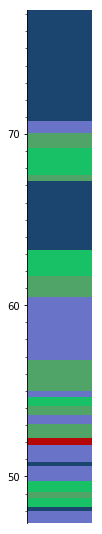

In [21]:
s.plot(aspect=5)

In [23]:
striplogs = []
for las_file in las_files:
    striplogs.append(log_section(las_file))

Now make a legend and add widths.

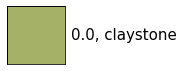

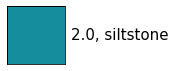

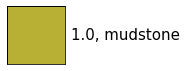

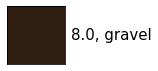

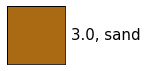

In [24]:
from striplog import Legend

comps = list(set(i.primary for i in s))
legend = Legend.random(comps)
legend.plot()

In [25]:
for d in legend:
    d.width = d.component['grainsize']

#### Plot the `striplog` with grain size widths

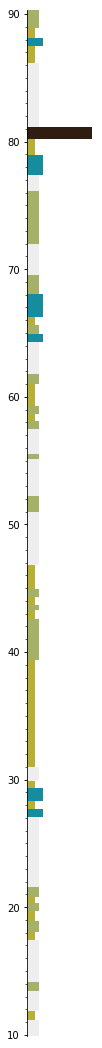

In [35]:
s.plot(legend=legend, ladder=True)

### Load again but with a shift, to make other `striplogs` in panel

In [31]:
intervals = []
for (top, gs), (base, _) in zip(l.data[:-1], l.data[1:]):
    properties = {
        'grainsize': gs,
        'lithology': lithologies[int(gs)] if not np.isnan(gs) else 'none',
    }
    comp = Component(properties=properties)
    interval = Interval(top=-top+10, base=-base+10, components=[comp])
    intervals.append(interval)

s2 = Striplog(intervals, order='elevation')

In [32]:
s[0]

Interval({'top': Position({'middle': 90.288, 'units': 'm'}), 'base': Position({'middle': 88.906, 'units': 'm'}), 'description': '', 'data': {}, 'components': [Component({'grainsize': 0.0, 'lithology': 'claystone'})]})

In [33]:
for d in legend:
    d.width = d.component['grainsize']

### Let's plot the `striplogs` into a panel

(0, 110)

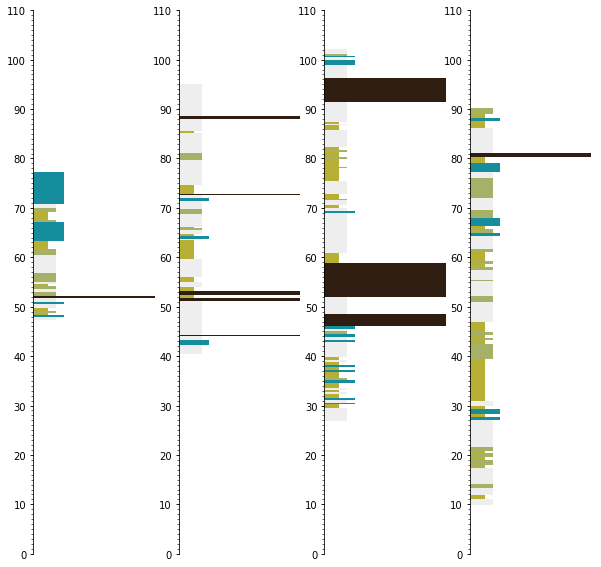

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(figsize=(10, 10), ncols=len(striplogs), sharey=True)

for i, s in enumerate(striplogs):
    
    ax = axs[i]
    ax = s.plot(ax=ax, legend=legend, ladder=True)

plt.ylim(0, 110)